> Heavily adopted code and format from greilliam

# Simulated Classifcation

1. State assumptions
2. Formally define classification/regression problem
3. provide algorithm for solving problem (including choosing hyperparameters as appropriate)
4. sample data from a simulation setting inspired by your data (from both null and alternative as defined before)
5. compute accuracy
6. plot accuracy vs. sample size in simulation
7. apply method directly on real data
8. explain the degree to which you believe the result and why

## Step 1: State assumptions



## Step 2: Formally define classification/regression problem

## Step 3: Provide algorithm for solving problem (including choosing hyperparameters as appropriate)

"Machine Learning" is usually classification or prediction
  - predictive is subject specific
  
Clarity brains have $(X, Y)$ ~iid $F_{xy}$ which is some distribution
  - X is subject 
  - Y is $\{0, 1\}$
  - Function g(x) spits out a class label (thus g is a classifier function)
  - G = {g: map from reals to {0, 1}}
    - Classifier takes a single x 
      - If $x>k$ but $<0$ is one classifier
      - Best clasisifier is statistical decision theory
        - Need to define a loss function that tells us how wrong we are
        - We need to choose classifier that minimizes loss
        - G* = $\underset{g \in G}{argmin} l(g(x), y)$
        - Squared error is a good option $(g(x)-y)^2$
          - Problem is that $(0-1)^2 = (1-0)^2$ so you don't know which side of the "wrong" you are
        - Absolute error is $|g(x)-y|$
        - Zero one error 
          - If $g(x)=y$ then $l=0$
          - If $g(y)!=y$ then $l=1$
    - If L is the set of loss functions 
      - L = {l: yxy -> Real+}
        - Here we are finding which scores are the best 
    - Definitions: Voxels, Priors, Baye's rule F_(x,y) = F_(x|y)F_y=F_(y|x)F_x ->  
      - $F_(x|y)=N(M_y. 1)$
      - $F_y = Bern(pi)$
      - Next need to fit the joint distribution 
        - After fitting the Bayes optimal is called the Bayes plugin
        - MLE - minimizing squared error
        - Sample n train sample (xi, yi) ~iid F_xx generate training data i∈[n_train]
        - estimate classifier theta
          - sample iidF_xy i∈[n_test]
          
    
    - Best classifier is called the Bayes Optimal
      - g* = argmax F_((x=(x)|(y)=y))
        - Can use a posterari if priors are not equal
          - F_(x=x, y=y) = F_(x|y)F_y
        - compute argmax for y∈y
          - Let y = 0 is .99 y-1 is .01
        
    - Next need to relect get change level accuracy which will almost definitely ahppen if you use a regular loss function 
      - Use histogram instead of image data
        - Classifier list:
          - LDA
            - Variances are the same 
            - Made by Fischer
            - Finds optimal linear classifier (optimal line) under the assumptions that we have made
              - Advantages: Very interpretable, Very fast, Linear
          - Random Forest
            - Decision tree thresholds are created
            - Choose a loss function and then try to do a greedy search
            - Find the optimal thresholds to maximize purity
            - Change thresholds to maximize purity so that most of one group is in one part and the others are in the others
            - Random Forest uses decision trees on subsets of your data, since each tree is noisy and can overfit, so averageing over many different classifiers it will be much more effective
            - This is an ensemble method 
              - Every single classifier is on a different point on the bias variance tradeoff so when you average everything it will be more consistent
          - SVM
          - Logistic
          - Neural Network
            - Uses linear algebra, runs on GPU
            - Takes in more information and is very useful for computer vision techniques
            - Natively do the classificiation
          - KNN
            - K nearest neighbor 
            - specify apriori k and find the distance between the points and K 
            - Assuming K is big enough, it will always converge irrespectively
            - Doesn't care about the distributions, but it is universally consistent
          - QDA
            - Quadratic descriminatory analysis
            - Optimal discriminatory boundary is curved
            - Covariance matrices


In [1]:
# change working dir
path = "/Users/david/Desktop/CourseWork/TheArtOfDataScience/claritycontrol/code/scripts" # use your own path
import os
os.chdir(path)

### Histogram data preparation

> Skip this step if the data are already baked, just eat them!

1. Set suitable data value range to get histogram from the majority of the datasets.

In [ ]:
import numpy as np
import clarity.resources as rs
import clarity as cl
import gc  # garbage memory collection :)

BINS=4
RANGE=(10.0,300.0)

# For testing, find the proper range.
# import matplotlib.pyplot as plt
# c = cl.Clarity("Cocaine178")
# hist, bin_edges = c.loadImg(info=False).getHistogram(bins=BINS,range=RANGE,density=True)
# width = 0.8*(bin_edges[1] - bin_edges[0])
# center = (bin_edges[:-1] + bin_edges[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.show()

for token in rs.TOKENS:
    c = cl.Clarity(token)
    hist, bin_edges = c.loadImg(info=False).getHistogram(bins=BINS,range=RANGE,density=False)
    fname = "../data/hist/"+token+".hist"
    np.savetxt(fname,hist,delimiter=',')
    # print fname,"saved."
    del c
    gc.collect()

### Scale data

In [ ]:
import numpy as np
import clarity.resources as rs
BINS = 4
features = np.empty(shape=(1,4))
for token in rs.TOKENS:
    fname = "../data/hist/"+token+".hist"
    data = np.loadtxt(fname,delimiter=',')
    features = np.vstack([features,data])
features = features[1:,]
minc = np.min(features)
maxc = np.max(features)
features = (features-minc)/(maxc-minc)
print features
np.savetxt("../data/hist/features.hist",features,delimiter=',')

### Setup Step

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import jgraph as ig

from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline

np.random.seed(12345678)  # for reproducibility, set random seed

# Cocaine = ["Cocaine174","Cocaine175","Cocaine178"]
# Control = ["Control181","Control182","Control189","Control239","Control258"]
# Fear = ["Fear187","Fear197","Fear199","Fear200"]

features = np.loadtxt("../data/hist/features.hist",delimiter=',')
temp_mu = np.mean(features,axis=1)
temp_std = np.std(features,axis=1)

mu = [np.mean(temp_mu[0:3]),np.mean(temp_mu[3:8]),np.mean(temp_mu[8:12])]
std = [np.mean(temp_std[0:3]),np.mean(temp_std[3:8]),np.mean(temp_std[8:12])]
print mu
print std
std=[1,1,1]

# define number of subjects per class
S = np.array((9, 21, 30, 39, 45, 63, 81, 96, 108, 210, 333))

names = ["Nearest Neighbors", "Linear SVM", "Random Forest",
         "Linear Discriminant Analysis", "Quadratic Discriminant Analysis"]

classifiers = [
    KNeighborsClassifier(3), # TODO: what is 3
    SVC(kernel="linear", C=0.5), # TODO: what is C
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis()]
#     QuadraticDiscriminantAnalysis()]

[0.23770897349869147, 0.17949098607239755, 0.16388957730669243]
[0.33325814318994945, 0.25244003850017155, 0.2346371954529729]


## Steps 4 & 5: Sample data from setting similar to data and record classification accuracy

In [4]:
accuracy = np.zeros((len(S), len(classifiers), 2), dtype=np.dtype('float64'))
for idx1, s in enumerate(S):
    s0=s/3
    s1=s/3
    s2=s/3
    
    x0 = np.random.normal(mu[0],std[0],(s0,4))
    x1 = np.random.normal(mu[1],std[1],(s1,4))
    x2 = np.random.normal(mu[2],std[2],(s2,4))
    X = x0
    X = np.vstack([X,x1])
    X = np.vstack([X,x2])
    y = np.append(np.append(np.zeros(s0), np.ones(s1)),np.ones(s2)*2)
    for idx2, cla in enumerate(classifiers):
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)
        clf = cla.fit(X_train, y_train)
        loo = LeaveOneOut(len(X))
        scores = cross_validation.cross_val_score(clf, X, y, cv=loo)
        accuracy[idx1, idx2,] = [scores.mean(), scores.std()]
        print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))
    
print accuracy

Accuracy of Nearest Neighbors: 0.00 (+/- 0.00)
Accuracy of Linear SVM: 0.00 (+/- 0.00)
Accuracy of Random Forest: 0.44 (+/- 0.99)
Accuracy of Linear Discriminant Analysis: 1.00 (+/- 0.00)
Accuracy of Nearest Neighbors: 0.33 (+/- 0.94)
Accuracy of Linear SVM: 0.29 (+/- 0.90)
Accuracy of Random Forest: 0.43 (+/- 0.99)
Accuracy of Linear Discriminant Analysis: 0.43 (+/- 0.99)
Accuracy of Nearest Neighbors: 0.43 (+/- 0.99)
Accuracy of Linear SVM: 0.37 (+/- 0.96)
Accuracy of Random Forest: 0.40 (+/- 0.98)
Accuracy of Linear Discriminant Analysis: 0.43 (+/- 0.99)
Accuracy of Nearest Neighbors: 0.26 (+/- 0.87)
Accuracy of Linear SVM: 0.28 (+/- 0.90)
Accuracy of Random Forest: 0.38 (+/- 0.97)
Accuracy of Linear Discriminant Analysis: 0.28 (+/- 0.90)
Accuracy of Nearest Neighbors: 0.47 (+/- 1.00)
Accuracy of Linear SVM: 0.47 (+/- 1.00)
Accuracy of Random Forest: 0.38 (+/- 0.97)
Accuracy of Linear Discriminant Analysis: 0.51 (+/- 1.00)
Accuracy of Nearest Neighbors: 0.30 (+/- 0.92)
Accuracy of L

## Step 6: Plot Accuracy versus N

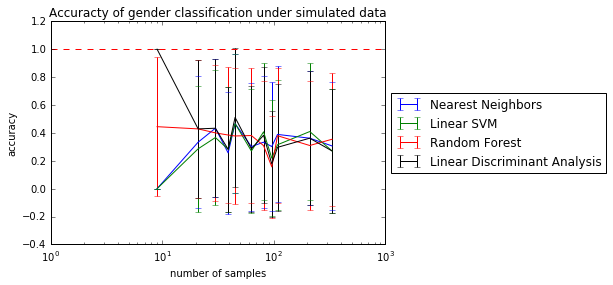

In [5]:
plt.errorbar(S, accuracy[:,0,0], yerr = accuracy[:,0,1], hold=True, label=names[0])
plt.errorbar(S, accuracy[:,1,0], yerr = accuracy[:,1,1], color='green', hold=True, label=names[1])
plt.errorbar(S, accuracy[:,2,0], yerr = accuracy[:,2,1], color='red', hold=True, label=names[2])
plt.errorbar(S, accuracy[:,3,0], yerr = accuracy[:,3,1], color='black', hold=True, label=names[3])
# plt.errorbar(S, accuracy[:,4,0], yerr = accuracy[:,4,1], color='brown', hold=True, label=names[4])
plt.xscale('log')
plt.xlabel('number of samples')
plt.ylabel('accuracy')
plt.title('Accuracty of gender classification under simulated data')
plt.axhline(1, color='red', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Step 7: Apply technique to data

In [6]:
y=np.array([0,0,0,1,1,1,1,1,2,2,2,2])
features = np.loadtxt("../data/hist/features.hist",delimiter=',')

In [7]:
accuracy=np.zeros((len(classifiers),2))
for idx, cla in enumerate(classifiers):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, y, test_size=0.4, random_state=0)
    clf = cla.fit(X_train, y_train)
    loo = LeaveOneOut(len(features))
    scores = cross_validation.cross_val_score(clf, features, y, cv=loo)
    accuracy[idx,] = [scores.mean(), scores.std()]
    print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2))

Accuracy of Nearest Neighbors: 0.00 (+/- 0.00)
Accuracy of Linear SVM: 0.25 (+/- 0.87)
Accuracy of Random Forest: 0.08 (+/- 0.55)
Accuracy of Linear Discriminant Analysis: 0.25 (+/- 0.87)


## Step 8: Reflect on result